<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

Draga Pihler-Puzovic<br>
University of Manchester  
January 2021

Assignment completed by Ksenija Kovalenka (ID: 10485506)

We first initialise our Python interpreter

In [1]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [2]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

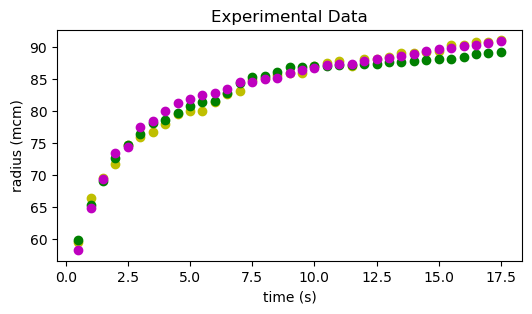

In [3]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(time, radius_data1, "yo")
plt.plot(time, radius_data2, "go")
plt.plot(time, radius_data3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius (mcm)")
plt.title("Experimental Data")
# displaying the plot
plt.show()

Don't forget to find the errors on $R$ estimated from the three experimental runs.

In [4]:
radius_errors = np.array([])
mean_radiuses = np.array([])

for index in range(len(radius_data1)):
    radius_error = np.std([radius_data1[index], radius_data2[index], radius_data3[index]])
    mean_radius = np.mean([radius_data1[index], radius_data2[index], radius_data3[index]])
    
    radius_errors = np.append(radius_errors, radius_error)
    mean_radiuses = np.append(radius_errors, mean_radius)

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

In [5]:
# creating a combined data array so that a loop can be made to run through three sets at once.
combined_data_set = np.vstack((radius_data1, radius_data2, radius_data3))

In [6]:
# calculating speed for all data sets.

total_speed_array = np.empty((0, 34)) # has to be done for stacking

for attempt_number in range(3):
    speed_U = np.array([])
    
    for index in range(len(combined_data_set[attempt_number]) - 1):
        speed = (combined_data_set[attempt_number][index + 1] - 
                 combined_data_set[attempt_number][index]) / (time[index + 1] - time[index])
        speed_U = np.append(speed_U, speed)
        
    total_speed_array = np.vstack((total_speed_array, speed_U))

In [7]:
# calculating the contact angle 𝜃 for all data sets.

VOLUME = 7.6e3 #micrometers^3

def cubic(height, volume, radius):
    """
    Returns zero for correct set of parameters, a function of height which has to be minimised.
    """
    return (height * np.pi / 6) * (3 * radius**2 + height**2) - volume


def contact_angle(radius, height):
    """
    Calculates a contact angle of a drop of specific radius and height with a surface.
    """
    angle = np.pi / 2 - np.arctan((radius**2 - height**2) / (2 * height * radius)) 
    return angle

heights_total = np.empty((0, 35))
angles_total = np.empty((0, 35))

h_0 = 1 * 10**-5

for attempt_number in range(3):
    angles = np.array([])
    heights = np.array([])
    
    for index in range(len(combined_data_set[attempt_number])):
        HEIGHT = fsolve(lambda x: cubic(x, VOLUME, combined_data_set[attempt_number][index]), h_0)
        ANGLE = contact_angle(combined_data_set[attempt_number][index], HEIGHT)
        angles = np.append(angles, ANGLE)
        heights = np.append(heights, HEIGHT)

    angles_total = np.vstack((angles_total, angles))
    heights_total = np.vstack((heights_total, heights))

Let's plot these results to see what they look like:

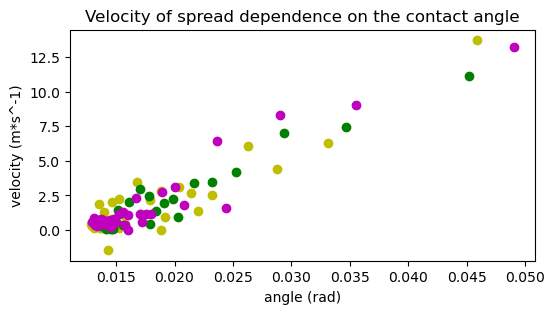

In [8]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
# [:-1] is required because the velocity of last data point can't be calclated

plt.plot(angles_total[0][:-1], total_speed_array[0], "yo")
plt.plot(angles_total[1][:-1], total_speed_array[1], "go")
plt.plot(angles_total[2][:-1], total_speed_array[2], "mo")
# setting axis labels & figures 
plt.xlabel("angle (rad)")
plt.ylabel("velocity (m*s^-1)")
plt.title("Velocity of spread dependence on the contact angle")
# displaying the plot
plt.show()

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

In [9]:
# calculating required quantities
mean_speeds = np.array([])
mean_angles = np.array([])
speed_uncerainties = np.array([])
angle_uncertanties = np.array([])

for index in range(len(total_speed_array[0])):
    mean_speed = np.mean(np.transpose(total_speed_array)[index])
    speed_uncertainty = np.std(np.transpose(total_speed_array)[index])
    mean_angle = np.mean(np.transpose(angles_total)[index])
    angle_uncertainty = np.std(np.transpose(angles_total)[index])
    
    mean_speeds = np.append(mean_speeds, mean_speed)
    mean_angles = np.append(mean_angles, mean_angle)
    speed_uncerainties = np.append(speed_uncerainties, speed_uncertainty)
    angle_uncertanties = np.append(angle_uncertanties, angle_uncertainty)

The final plot of mean speed $U$ against mean angle $\theta$.

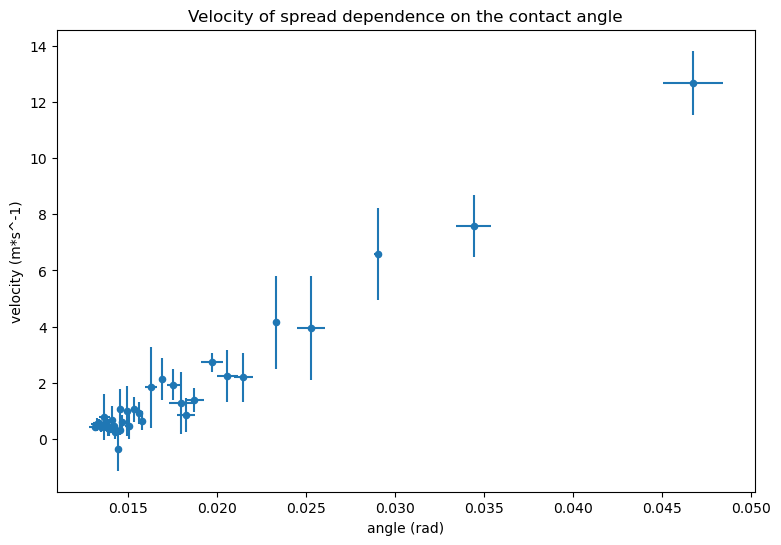

In [10]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (9,6)
plt.figure()
# plotting results
plt.scatter(mean_angles, mean_speeds, s=20)
plt.errorbar(mean_angles, mean_speeds, speed_uncerainties, angle_uncertanties, linestyle=' ')
# setting axis labels & figures 
plt.xlabel("angle (rad)")
plt.ylabel("velocity (m*s^-1)")
plt.title("Velocity of spread dependence on the contact angle")
# displaying the plot
plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [11]:
parameters_2, covariant_m_2 = np.polyfit(mean_angles**2, mean_speeds, 1, cov=True)
parameters_3, covariant_m_3 = np.polyfit(mean_angles**3, mean_speeds, 1, cov=True)

The corresponding $\delta\theta^{fit}$ calculation:

In [12]:
# square fit
characteristic_speed_2 = parameters_2[0]
error_characteristic_speed_2 = np.sqrt(covariant_m_2[0][0])

equilibrium_angle_2 = np.sqrt(-parameters_2[1] / characteristic_speed_2)
error_equilibrium_angle_2 = (equilibrium_angle_2 / 2) * np.sqrt((np.sqrt(covariant_m_2[1][1]) / parameters_2[1])**2 
                                                                + (error_characteristic_speed_2 / characteristic_speed_2)**2)

# cubic fit
characteristic_speed_3 = parameters_3[0]
error_characteristic_speed_3 = np.sqrt(covariant_m_3[0][0])

equilibrium_angle_3 = np.cbrt(-parameters_3[1] / characteristic_speed_3)
error_equilibrium_angle_3 = (equilibrium_angle_3 / 3) * np.sqrt((np.sqrt(covariant_m_3[1][1]) / parameters_3[1])**2 
                                                                + (error_characteristic_speed_3 / characteristic_speed_3)**2)

Displaying the corresponding fits  

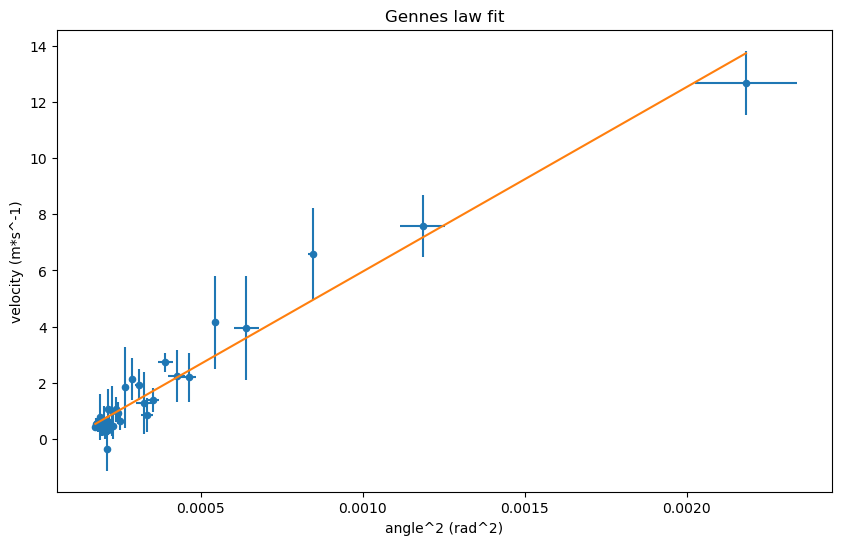

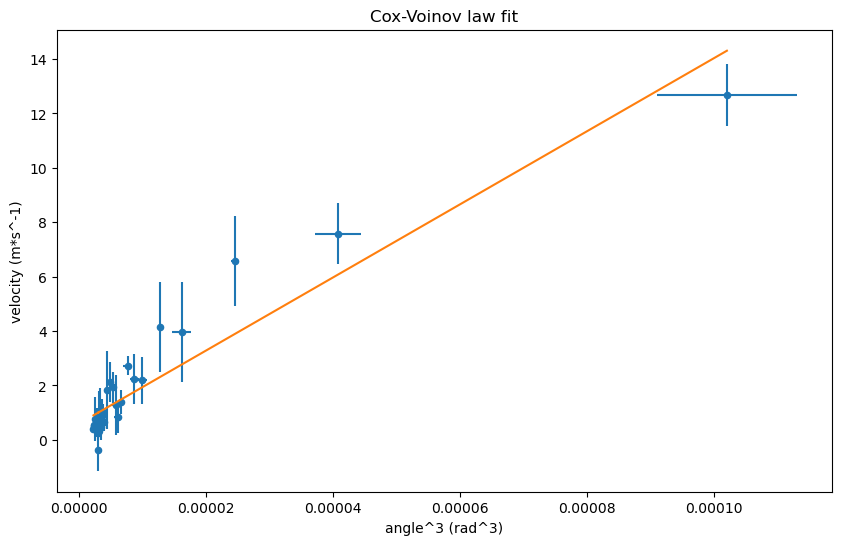

In [13]:
# write your code here
speed_2 = parameters_2[0] * mean_angles**2 + parameters_2[1]
speed_3 = parameters_3[0] * mean_angles**3 + parameters_3[1]

# plot for Gennes law
figure = plt.figure(figsize=(10, 6))
axis_1 = figure.add_subplot(111)
axis_1.scatter(mean_angles**2, mean_speeds, s=20)
axis_1.errorbar(mean_angles**2, mean_speeds, yerr=speed_uncerainties, xerr=angle_uncertanties * 2 * mean_angles, linestyle=' ')
axis_1.plot(mean_angles**2, speed_2)
axis_1.set_xlabel("angle^2 (rad^2)")
axis_1.set_ylabel("velocity (m*s^-1)")
axis_1.set_title("Gennes law fit")
plt.show()

# plot for Cox-Voinov law
figure = plt.figure(figsize=(10, 6))
axis_2 = figure.add_subplot(111)
axis_2.scatter(mean_angles**3, mean_speeds, s=20)
axis_2.errorbar(mean_angles**3, mean_speeds, speed_uncerainties, angle_uncertanties * 3 * mean_angles**2 , linestyle=' ')
axis_2.plot(mean_angles**3, speed_3)
axis_2.set_xlabel("angle^3 (rad^3)")
axis_2.set_ylabel("velocity (m*s^-1)")
axis_2.set_title("Cox-Voinov law fit")
plt.show()

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. For the model which fits the data, reduced chi-squared is expected to have a value from 0.5 to 1.5. The case is further strengthened using the residual plots. 

In [14]:
# chi squared function

def chi_squared(prediction, data, uncertainty):
    """
    Calculates the value of chi squared for the fit.

    Parameters
    ----------
    prediction : array of floats
    data : array of floats
    uncertainty : array of floats

    Returns
    -------
    Chi squared : float

    """

    return np.sum(((prediction - data) / uncertainty)**2)

In [15]:
# square fit

chi_2 = chi_squared(speed_2, mean_speeds, speed_uncerainties)
print('reduced chi-squared for a square fit: {}'.format(chi_2 / (len(mean_angles) - 2)))

reduced chi-squared for a square fit: 1.069378885911398


In [16]:
# cubic 

chi_3 = chi_squared(speed_3, mean_speeds, speed_uncerainties)
print('reduced chi-squared for a cubic fit: {}'.format(chi_3 / (len(mean_angles) - 2)))

reduced chi-squared for a cubic fit: 3.4946373678340277


Residuals plots

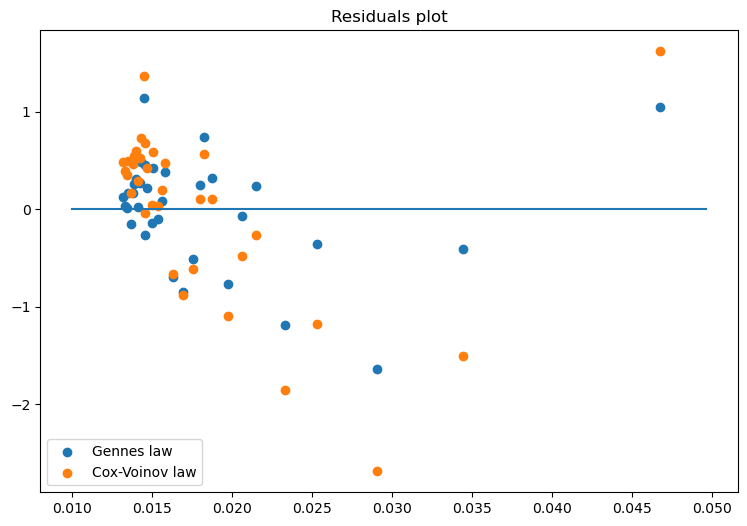

In [17]:
plt.scatter(mean_angles, speed_2 - mean_speeds, label='Gennes law')
plt.scatter(mean_angles, speed_3 - mean_speeds, label='Cox-Voinov law')
plt.plot(np.arange(0.01, 0.05, 0.04 / 100), np.zeros(100))
plt.title('Residuals plot')
plt.legend(loc='lower left')
plt.show()

![](./img/bee.png)
## Drop Spreading Law Is Gennes law

The results of the chi-squared analysis suggest that the "Gennes law" is a better fit for the behaviour of the spreading drop because it gives better reduced chi-squared (very close to 1). For Cox-Voinov law, both reduced chi-squared analysis and residuals plot show that data points are too spread out about the predicted line, so the model doesn't fit the data well enough.

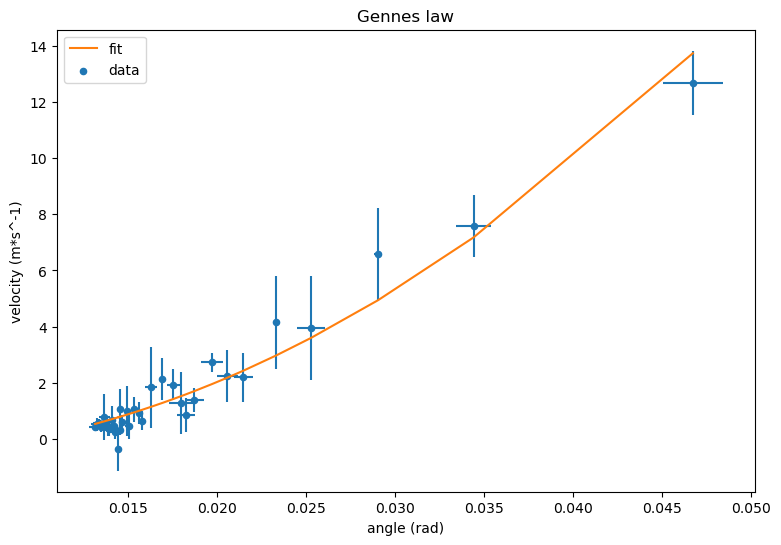

In [22]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (9,6)
plt.figure()
# plotting results
plt.scatter(mean_angles, mean_speeds, s=20, label='data')
plt.errorbar(mean_angles, mean_speeds, speed_uncerainties, angle_uncertanties, linestyle=' ')
plt.plot(mean_angles, characteristic_speed_2 * (mean_angles ** 2 - equilibrium_angle_2 ** 2), label='fit')
# setting axis labels & figures 
plt.xlabel("angle (rad)")
plt.ylabel("velocity (m*s^-1)")
plt.title("Gennes law")
plt.legend()
# displaying the plot
plt.show()

![](./img/bee.png)
## Stretch yourself section

This section is to be populated by you entirely 

Questions:

1) What are we supposed to write in the last bit?

2) Why do we calculate mean R, sigma R, and uncertainties associated with the fit, if we don't use them anywhere alse in the analysis?
